In [1]:
from keras.backend import clear_session

clear_session()


In [2]:
# Import needed libraries
%reload_ext tensorboard

import datetime

# Data containers
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Manipulation and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import LinearSVR
from sklearn.naive_bayes import MultinomialNB

#Hugging face dataset loading
from datasets import load_dataset
from transformers import pipeline

In [57]:
# Deep_Learning
# import tensorflow_datasets as tfds
import numpy
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Activation, Bidirectional, Conv2D, MaxPooling2D, add, Dense, UpSampling2D, Reshape
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# This code snippet forces tensorflow to not automatically allocate all GPU ram which can be an issue in notebook environment
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
tf.debugging.disable_traceback_filtering()

1 Physical GPUs, 1 Logical GPUs


In [4]:
import os
# Force Tensorflow to use my GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '1'






We have applied the 
residual connection after two convolutional layer
size of filters is 3*3, consistently maintained for whole network. 

**In the encoder part, the size of first residual block is 256 * 256, second and third blocks are of size 128 * 128 and 64 * 64**

In decoder part
the reverse way, starting with 64 * 64 residual block. 

**In between, the hourglass module is based on residual blocks along with skip
connections, as can be seen in Fig. 2. The residual blocks are labeled
as R1;R2;R3;R4;R5;R6;R7;R8;R9, each of which consists of
three convolutional layers**


---------------------------------------


**The batch size is chosen to be 8**. 

**Resized the images to 256 * 256 for Ikea and
128 * 128 for NYU V2 Depth dataset**

However, our network is flexible to take input images as 
in square matrix (64 * 64; 128 * 128 : : : 512 * 512 . . . ) form


----------------------------------------
As our network does not involve any pre-trained weights, we
first train the network using the MSE loss for some epochs. Following
this, in our case, the ground-truth depth map and the estimated
depth map, are passed through the network, and the loss is measured
by using feature maps of the second last layer of encoder before the
hourglass. This can also be called as a feature reconstruction loss
between the predicted map and the ground truth



In [123]:
def create_models(dropout = False, dropout_rate = 0.2, model_name = 'base', input_shape =(256, 256, 3), filters = 1):
    
    # The input size is dependent on the dataset being used
    input_shape = input_shape
    
    # Constantly maintain the filter size of 3x3 thought the whole model    
    filter_size = (3,3)
    
    input_layer = keras.Input(input_shape, name = 'input_layer')
    
    if model_name == 'base': # Base model as described in the research paper
        
        
        
        if not dropout:
            
            # As the model requires intervention with the results, the values have to be stored
            # Cannot simply be created using model.add(layers) - if wanted layerName.output would have to be used
            
            # -----Encoding CNN Block----- # 
            # The layers will be labeled as shown in the research paper
            # There is a residual connection after every 2 convolution layers
                
            # Convolution block 1 
            
            # filters = # of filters, 
            # kernel_size = filter size - single value - assumes the filter is a square, 
            # padding = valid - no padding, same - padding evenly to the input, 
            # stride = how much does the filter move (assume 1 in this case)
            # padding='same', activation = padding='same', activation function - need to test with relu and none
            # use_bias = if True then it is used, we assume there is none, as there are no pretrained weights - can test with both
            conv1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(input_layer)
            
            # Convolution Block 2
            conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv1)
            conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv2)
            
            # Residual Connection from Conv1 output to Conv4 Input
            # Add (Conv layer before input, output from the layer it is being connected to)
            Residual1 = add([conv3, conv1])
            
            # Convolution Block 3
            conv4 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual1)
            # Using a 2D Max Pooling as the input is a 2D image
            # Assume pooling size is 2,2 as default
            pool1 = MaxPooling2D(2, padding = 'same')(conv4)
            #filters = filters*2
            
            # Convolution Block 4
            conv5 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(pool1)
            conv6 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv5)
            
            # Residual Connection from Pool1 output to Conv7 input
            Residual2 = add([conv6, pool1])
            
            # Convolution Block 5
            conv7 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual2)
            pool2 = MaxPooling2D(2, padding = 'same')(conv7)
            #filters = filters*2
            
            #Convolution Block 6
            conv8 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(pool2)
            conv9 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv8)
            
            # Residual Connection from Pool2 output to Conv10 input
            Residual3 = add([conv9, pool2])
            
            # Convoluton Block 7
            conv10 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual3)
            pool3 = MaxPooling2D(2, padding = 'same')(conv10)
            #filters = filters*2
            
            # The output will change accordingly to where the LSTM is being placed in other models
            output = pool3
            
            # Bottom up structure consists of convolution and max-pooling layers
            # Up-Sampling and combination of features in Top-down manner
            # Encoder
            # 1st block - 256x256
            # 2nd block - 128x128
            # 3rd block - 64x64
            
            # Assuming middle sections are 32x32
            
            # Decoder
            # 7th block - 64x64
            # 8th block - 128x128
            # 9th block - 256x256
            
            # -----Hourglass Encoder-Decoder----- #
            
            # Bottom - up
            # R1 Block
            R1 = Conv2D(filters, kernel_size=256, padding='same', activation='relu')(output)
            R1 = MaxPooling2D(2, padding='same')(R1)
            
            # R2 Block
            R2 = Conv2D(filters, kernel_size=128, padding='same', activation='relu')(R1)
            R2 = MaxPooling2D(2, padding='same')(R2)
            
            # R3 Block
            R3 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R2)
            R3 = MaxPooling2D(2, padding='same')(R3)
            
            
            # Middle
            # R4 Block
            R4 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R3)
            R4 = MaxPooling2D(2, padding='same')(R4)
            
            
            # R5 Block
            R5 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R4)
            R5 = MaxPooling2D(2, padding='same')(R5)
            
            
            # R6 Block
            R6 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R5)
            R6 = MaxPooling2D(2, padding='same')(R6)
            
            Residual = add([R6, R3])
            # Top- Down
            # R7 Block
            R7 = UpSampling2D(2, interpolation='nearest')(Residual)
            R7 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R7)
            
            # R8 Block
            Residual = add([R7, R2])
            R8 = UpSampling2D(2, interpolation='nearest')(Residual)
            R8 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R8)
        
            # R9 Block
            
            Residual = add([R8, R1])
            R9 = UpSampling2D(2, interpolation='nearest')(Residual)
            R9 = Conv2D(filters, kernel_size=256, padding='same')(R9)
            
            output = R9
        
            # -----Hourglass Encode-Decoder----- #
            
            # Bottom - up
            # R1 Block
            R1 = Conv2D(filters, kernel_size=256, padding='same')(output)
            R1 = MaxPooling2D(2, padding='same')(R1)
            
            # R2 Block
            R2 = Conv2D(filters, kernel_size=128, padding='same', activation='relu')(R1)
            R2 = MaxPooling2D(2, padding='same')(R2)
            
            # R3 Block
            R3 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R2)
            R3 = MaxPooling2D(2, padding='same')(R3)
            
            
            # Middle
            # R4 Block
            R4 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R3)
            R4 = MaxPooling2D(2, padding='same')(R4)
            
            
            # R5 Block
            R5 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R4)
            R5 = MaxPooling2D(2, padding='same')(R5)
            
            
            # R6 Block
            R6 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R5)
            R6 = MaxPooling2D(2, padding='same')(R6)
            
            Residual = add([R6, R3])
            # Top- Down
            # R7 Block
            R7 = UpSampling2D(2, interpolation='nearest')(Residual)
            R7 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R7)
            
            # R8 Block
            Residual = add([R7, R2])
            R8 = UpSampling2D(2, interpolation='nearest')(Residual)
            R8 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R8)
        
            # R9 Block
            
            Residual = add([R8, R1])
            R9 = UpSampling2D(2, interpolation='nearest')(Residual)
            R9 = Conv2D(filters, kernel_size=256, padding='same')(R9)
            
            output = R9
            
            # -----Decoding CNN Block----- #
            upconv1 = UpSampling2D(2, interpolation='nearest')(output)
            conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv1)
            
            # Convolution Block 2
            conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv2)
            conv4 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv3)
            
            # Residual Connection from Conv1 output to Conv4 Input
            # Add (Conv layer before input, output from the layer it is being connected to)
            Residual1 = add([conv2, conv4])
            
            # Convolution Block 3
            conv5 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual1)
            upconv6 = UpSampling2D(2, interpolation='nearest')(conv5)
            #filters = filters*2
            
            # Convolution Block 4
            conv7 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv6)
            conv8 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv7)
            
            # Residual Connection from Pool1 output to Conv7 input
            Residual2 = add([upconv6, conv8])
            
            # Convolution Block 5
            conv9 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual2)
            upconv10 = UpSampling2D(2, interpolation='nearest')(conv9)
            
            # Convoluton Block 7
            conv11 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv10)
            conv12 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv11)
            #filters = filters*2
            
            print(conv10.shape, conv12.shape)
            
            # Residual Connection from Pool2 output to Conv10 input
            Residual3 = add([upconv10, conv12])
            
            
            # Convolution Block 8
            conv13 = Conv2D(filters, kernel_size=3, padding='same', activation = 'relu')(Residual3)
            
            
            output_layer = conv13  # Adjust the number of units for your specific task

            model = Model(input_layer, output_layer, name = 'Base Model')

            return model
        
        
    if model_name == 'CNN-LSTM1': # Check if the location of the LSTM affects the models - before hourglass
        if not dropout:

            # As the model requires intervention with the results, the values have to be stored
            # Cannot simply be created using model.add(layers) - if wanted layerName.output would have to be used
            
            # -----Encoding CNN Block----- # 
            # The layers will be labeled as shown in the research paper
            # There is a residual connection after every 2 convolution layers
                
            # Convolution block 1 
            
            # filters = # of filters, 
            # kernel_size = filter size - single value - assumes the filter is a square, 
            # padding = valid - no padding, same - padding evenly to the input, 
            # stride = how much does the filter move (assume 1 in this case)
            # padding='same', activation = padding='same', activation function - need to test with relu and none
            # use_bias = if True then it is used, we assume there is none, as there are no pretrained weights - can test with both
            conv1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(input_layer)
            
            # Convolution Block 2
            conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv1)
            conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv2)
            
            # Residual Connection from Conv1 output to Conv4 Input
            # Add (Conv layer before input, output from the layer it is being connected to)
            Residual1 = add([conv3, conv1])
            
            # Convolution Block 3
            conv4 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual1)
            # Using a 2D Max Pooling as the input is a 2D image
            # Assume pooling size is 2,2 as default
            pool1 = MaxPooling2D(2, padding = 'same')(conv4)
            #filters = filters*2
            
            # Convolution Block 4
            conv5 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(pool1)
            conv6 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv5)
            
            # Residual Connection from Pool1 output to Conv7 input
            Residual2 = add([conv6, pool1])
            
            # Convolution Block 5
            conv7 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual2)
            pool2 = MaxPooling2D(2, padding = 'same')(conv7)
            #filters = filters*2
            
            #Convolution Block 6
            conv8 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(pool2)
            conv9 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv8)
            
            # Residual Connection from Pool2 output to Conv10 input
            Residual3 = add([conv9, pool2])
            
            # Convoluton Block 7
            conv10 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual3)
            pool3 = MaxPooling2D(2, padding = 'same')(conv10)
            #filters = filters*2
            
            # The output will change accordingly to where the LSTM is being placed in other models
            output = pool3
            
            
            # ----- LSTM ----- #
            lstm1 = Reshape((32*32, 3))(output)
            lstm1_out = LSTM(units = 3, activation= 'relu', return_sequences=True)(lstm1)             
            
            lstm1_output = Reshape((32,32,3))(lstm1_out)

            
            
            # -----Hourglass Encoder-Decoder----- #
            
            # Bottom up structure consists of convolution and max-pooling layers
            # Up-Sampling and combination of features in Top-down manner
            # Encoder
            # 1st block - 256x256
            # 2nd block - 128x128
            # 3rd block - 64x64
            
            # Assuming middle sections are 32x32
            
            # Decoder
            # 7th block - 64x64
            # 8th block - 128x128
            # 9th block - 256x256
            
            
            # Bottom - up
            # R1 Block
            R1 = Conv2D(filters, kernel_size=256, padding='same')(lstm1_output)
            R1 = MaxPooling2D(2, padding='same')(R1)
            
            # R2 Block
            R2 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R1)
            R2 = MaxPooling2D(2, padding='same')(R2)
            
            # R3 Block
            R3 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R2)
            R3 = MaxPooling2D(2, padding='same')(R3)
            
            
            # Middle
            # R4 Block
            R4 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R3)
            R4 = MaxPooling2D(2, padding='same')(R4)
            
            
            # R5 Block
            R5 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R4)
            R5 = MaxPooling2D(2, padding='same')(R5)
            
            
            # R6 Block
            R6 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R5)
            R6 = MaxPooling2D(2, padding='same')(R6)
            
            Residual = add([R6, R3])
            # Top- Down
            # R7 Block
            R7 = UpSampling2D(2, interpolation='nearest')(Residual)
            R7 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R7)
            
            # R8 Block
            Residual = add([R7, R2])
            R8 = UpSampling2D(2, interpolation='nearest')(Residual)
            R8 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R8)
        
            # R9 Block
            
            Residual = add([R8, R1])
            R9 = UpSampling2D(2, interpolation='nearest')(Residual)
            R9 = Conv2D(filters, kernel_size=256, padding='same')(R9)
            
            output = R9
        
            # -----Hourglass Encode-Decoder----- #
            
            # Bottom - up
            # R1 Block
            R1 = Conv2D(filters, kernel_size=256, padding='same')(output)
            R1 = MaxPooling2D(2, padding='same')(R1)
            
            # R2 Block
            R2 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R1)
            R2 = MaxPooling2D(2, padding='same')(R2)
            
            # R3 Block
            R3 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R2)
            R3 = MaxPooling2D(2, padding='same')(R3)
            
            
            # Middle
            # R4 Block
            R4 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R3)
            R4 = MaxPooling2D(2, padding='same')(R4)
            
            
            # R5 Block
            R5 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R4)
            R5 = MaxPooling2D(2, padding='same')(R5)
            
            
            # R6 Block
            R6 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R5)
            R6 = MaxPooling2D(2, padding='same')(R6)
            
            Residual = add([R6, R3])
            # Top- Down
            # R7 Block
            R7 = UpSampling2D(2, interpolation='nearest')(Residual)
            R7 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R7)
            
            # R8 Block
            Residual = add([R7, R2])
            R8 = UpSampling2D(2, interpolation='nearest')(Residual)
            R8 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R8)
        
            # R9 Block
            
            Residual = add([R8, R1])
            R9 = UpSampling2D(2, interpolation='nearest')(Residual)
            R9 = Conv2D(filters, kernel_size=256, padding='same')(R9)
            
            output = R9
            
            Residual = add([R9, lstm1_output])
            
            # -----Decoding CNN Block----- #
            upconv1 = UpSampling2D(2, interpolation='nearest')(output)
            conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv1)
            
            # Convolution Block 2
            conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv2)
            conv4 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv3)
            
            # Residual Connection from Conv1 output to Conv4 Input
            # Add (Conv layer before input, output from the layer it is being connected to)
            Residual1 = add([conv2, conv4])
            
            # Convolution Block 3
            conv5 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual1)
            upconv6 = UpSampling2D(2, interpolation='nearest')(conv5)
            #filters = filters*2
            
            # Convolution Block 4
            conv7 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv6)
            conv8 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv7)
            
            # Residual Connection from Pool1 output to Conv7 input
            Residual2 = add([upconv6, conv8])
            
            # Convolution Block 5
            conv9 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual2)
            upconv10 = UpSampling2D(2, interpolation='nearest')(conv9)
            
            # Convoluton Block 7
            conv11 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv10)
            conv12 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv11)
            #filters = filters*2
            
            
            # Residual Connection from Pool2 output to Conv10 input
            Residual3 = add([upconv10, conv12])
            
            # Convolution Block 8
            conv13 = Conv2D(filters, kernel_size=3, padding='same', activation = 'relu')(Residual3)
            
            
            output_layer = conv13  # Adjust the number of units for your specific task

            model = Model(input_layer, output_layer, name = 'LSTM before Hourglass')

            return model
            
    if model_name == 'CNN-LSTM2': # Check if the location of the LSTM affects the models - after the hourglass
        if not dropout:
            
            # As the model requires intervention with the results, the values have to be stored
            # Cannot simply be created using model.add(layers) - if wanted layerName.output would have to be used
            
            # -----Encoding CNN Block----- # 
            # The layers will be labeled as shown in the research paper
            # There is a residual connection after every 2 convolution layers
                
            # Convolution block 1 
            
            # filters = # of filters, 
            # kernel_size = filter size - single value - assumes the filter is a square, 
            # padding = valid - no padding, same - padding evenly to the input, 
            # stride = how much does the filter move (assume 1 in this case)
            # padding='same', activation = padding='same', activation function - need to test with relu and none
            # use_bias = if True then it is used, we assume there is none, as there are no pretrained weights - can test with both
            conv1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(input_layer)
            
            # Convolution Block 2
            conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv1)
            conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv2)
            
            # Residual Connection from Conv1 output to Conv4 Input
            # Add (Conv layer before input, output from the layer it is being connected to)
            Residual1 = add([conv3, conv1])
            
            # Convolution Block 3
            conv4 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual1)
            # Using a 2D Max Pooling as the input is a 2D image
            # Assume pooling size is 2,2 as default
            pool1 = MaxPooling2D(2, padding = 'same')(conv4)
            #filters = filters*2
            
            # Convolution Block 4
            conv5 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(pool1)
            conv6 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv5)
            
            # Residual Connection from Pool1 output to Conv7 input
            Residual2 = add([conv6, pool1])
            
            # Convolution Block 5
            conv7 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual2)
            pool2 = MaxPooling2D(2, padding = 'same')(conv7)
            #filters = filters*2
            
            #Convolution Block 6
            conv8 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(pool2)
            conv9 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv8)
            
            # Residual Connection from Pool2 output to Conv10 input
            Residual3 = add([conv9, pool2])
            
            # Convoluton Block 7
            conv10 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual3)
            pool3 = MaxPooling2D(2, padding = 'same')(conv10)
            #filters = filters*2
            
            # The output will change accordingly to where the LSTM is being placed in other models
            output = pool3
            
            # -----Hourglass Encoder-Decoder----- #
            
            # Bottom up structure consists of convolution and max-pooling layers
            # Up-Sampling and combination of features in Top-down manner
            # Encoder
            # 1st block - 256x256
            # 2nd block - 128x128
            # 3rd block - 64x64
            
            # Assuming middle sections are 32x32
            
            # Decoder
            # 7th block - 64x64
            # 8th block - 128x128
            # 9th block - 256x256
            
            # Bottom - up
            # R1 Block
            R1 = Conv2D(filters, kernel_size=256, padding='same')(output)
            R1 = MaxPooling2D(2, padding='same')(R1)
            
            # R2 Block
            R2 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R1)
            R2 = MaxPooling2D(2, padding='same')(R2)
            
            # R3 Block
            R3 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R2)
            R3 = MaxPooling2D(2, padding='same')(R3)
            
            
            # Middle
            # R4 Block
            R4 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R3)
            R4 = MaxPooling2D(2, padding='same')(R4)
            
            
            # R5 Block
            R5 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R4)
            R5 = MaxPooling2D(2, padding='same')(R5)
            
            
            # R6 Block
            R6 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R5)
            R6 = MaxPooling2D(2, padding='same')(R6)
            
            Residual = add([R6, R3])
            # Top- Down
            # R7 Block
            R7 = UpSampling2D(2, interpolation='nearest')(Residual)
            R7 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R7)
            
            # R8 Block
            Residual = add([R7, R2])
            R8 = UpSampling2D(2, interpolation='nearest')(Residual)
            R8 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R8)
        
            # R9 Block
            
            Residual = add([R8, R1])
            R9 = UpSampling2D(2, interpolation='nearest')(Residual)
            R9 = Conv2D(filters, kernel_size=256, padding='same')(R9)
            
            output = R9
        
            # -----Hourglass Encode-Decoder----- #
            
            # Bottom - up
            # R1 Block
            R1 = Conv2D(filters, kernel_size=256, padding='same')(output)
            R1 = MaxPooling2D(2, padding='same')(R1)
            
            # R2 Block
            R2 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R1)
            R2 = MaxPooling2D(2, padding='same')(R2)
            
            # R3 Block
            R3 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R2)
            R3 = MaxPooling2D(2, padding='same')(R3)
            
            
            # Middle
            # R4 Block
            R4 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R3)
            R4 = MaxPooling2D(2, padding='same')(R4)
            
            
            # R5 Block
            R5 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R4)
            R5 = MaxPooling2D(2, padding='same')(R5)
            
            
            # R6 Block
            R6 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R5)
            R6 = MaxPooling2D(2, padding='same')(R6)
            
            Residual = add([R6, R3])
            # Top- Down
            # R7 Block
            R7 = UpSampling2D(2, interpolation='nearest')(Residual)
            R7 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R7)
            
            # R8 Block
            Residual = add([R7, R2])
            R8 = UpSampling2D(2, interpolation='nearest')(Residual)
            R8 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R8)
        
            # R9 Block
            
            Residual = add([R8, R1])
            R9 = UpSampling2D(2, interpolation='nearest')(Residual)
            R9 = Conv2D(filters, kernel_size=256, padding='same')(R9)
            
            output = R9
            
            
            # ----- LSTM ----- #
            lstm1 = Reshape((32*32, 3))(output)
            lstm1_out = LSTM(units = 3, activation= 'relu', return_sequences=True)(lstm1)             
            
            output = Reshape((32,32,3))(lstm1_out)
            
            residual = add([output, R9])
            
            # -----Decoding CNN Block----- #
            upconv1 = UpSampling2D(2, interpolation='nearest')(residual)
            conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv1)
            
            # Convolution Block 2
            conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv2)
            conv4 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv3)
            
            # Residual Connection from Conv1 output to Conv4 Input
            # Add (Conv layer before input, output from the layer it is being connected to)
            Residual1 = add([conv2, conv4])
            
            # Convolution Block 3
            conv5 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual1)
            upconv6 = UpSampling2D(2, interpolation='nearest')(conv5)
            #filters = filters*2
            
            # Convolution Block 4
            conv7 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv6)
            conv8 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv7)
            
            # Residual Connection from Pool1 output to Conv7 input
            Residual2 = add([upconv6, conv8])
            
            # Convolution Block 5
            conv9 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual2)
            upconv10 = UpSampling2D(2, interpolation='nearest')(conv9)
            
            # Convoluton Block 7
            conv11 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv10)
            conv12 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv11)
            #filters = filters*2
            
            
            # Residual Connection from Pool2 output to Conv10 input
            Residual3 = add([upconv10, conv12])
            
            # Convolution Block 8
            conv13 = Conv2D(filters, kernel_size=3, padding='same', activation = 'relu')(Residual3)
            
            
            output_layer = conv13  # Adjust the number of units for your specific task

            model = Model(input_layer, output_layer)

            return model
            
    if model_name == 'CNN-2LSTM': # model which will have the LSTM before and after the hourglass
        if not dropout:
            
            # As the model requires intervention with the results, the values have to be stored
            # Cannot simply be created using model.add(layers) - if wanted layerName.output would have to be used
            
            # -----Encoding CNN Block----- # 
            # The layers will be labeled as shown in the research paper
            # There is a residual connection after every 2 convolution layers
                
            # Convolution block 1 
            
            # filters = # of filters, 
            # kernel_size = filter size - single value - assumes the filter is a square, 
            # padding = valid - no padding, same - padding evenly to the input, 
            # stride = how much does the filter move (assume 1 in this case)
            # padding='same', activation = padding='same', activation function - need to test with relu and none
            # use_bias = if True then it is used, we assume there is none, as there are no pretrained weights - can test with both
            conv1 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(input_layer)
            
            # Convolution Block 2
            conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv1)
            conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv2)
            
            # Residual Connection from Conv1 output to Conv4 Input
            # Add (Conv layer before input, output from the layer it is being connected to)
            Residual1 = add([conv3, conv1])
            
            # Convolution Block 3
            conv4 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual1)
            # Using a 2D Max Pooling as the input is a 2D image
            # Assume pooling size is 2,2 as default
            pool1 = MaxPooling2D(2, padding = 'same')(conv4)
            #filters = filters*2
            
            # Convolution Block 4
            conv5 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(pool1)
            conv6 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv5)
            
            # Residual Connection from Pool1 output to Conv7 input
            Residual2 = add([conv6, pool1])
            
            # Convolution Block 5
            conv7 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual2)
            pool2 = MaxPooling2D(2, padding = 'same')(conv7)
            #filters = filters*2
            
            #Convolution Block 6
            conv8 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(pool2)
            conv9 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv8)
            
            # Residual Connection from Pool2 output to Conv10 input
            Residual3 = add([conv9, pool2])
            
            # Convoluton Block 7
            conv10 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual3)
            pool3 = MaxPooling2D(2, padding = 'same')(conv10)
            #filters = filters*2
            
            # The output will change accordingly to where the LSTM is being placed in other models
            output = pool3
            
            
            
            # ----- LSTM ----- #
            lstm1 = Reshape((32*32, 3))(output)
            lstm1_out = LSTM(units = 3, activation= 'relu', return_sequences=True)(lstm1)             
            
            output = Reshape((32,32,3))(lstm1_out)
            
            residual = add([output, pool3])
            

            # -----Hourglass Encoder-Decoder----- #
            
            # Bottom up structure consists of convolution and max-pooling layers
            # Up-Sampling and combination of features in Top-down manner
            # Encoder
            # 1st block - 256x256
            # 2nd block - 128x128
            # 3rd block - 64x64
            
            # Assuming middle sections are 32x32
            
            # Decoder
            # 7th block - 64x64
            # 8th block - 128x128
            # 9th block - 256x256
                        
            # Bottom - up
            # R1 Block
            R1 = Conv2D(filters, kernel_size=256, padding='same')(residual)
            R1 = MaxPooling2D(2, padding='same')(R1)
            
            # R2 Block
            R2 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R1)
            R2 = MaxPooling2D(2, padding='same')(R2)
            
            # R3 Block
            R3 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R2)
            R3 = MaxPooling2D(2, padding='same')(R3)
            
            
            # Middle
            # R4 Block
            R4 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R3)
            R4 = MaxPooling2D(2, padding='same')(R4)
            
            
            # R5 Block
            R5 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R4)
            R5 = MaxPooling2D(2, padding='same')(R5)
            
            
            # R6 Block
            R6 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R5)
            R6 = MaxPooling2D(2, padding='same')(R6)
            
            Residual = add([R6, R3])
            # Top- Down
            # R7 Block
            R7 = UpSampling2D(2, interpolation='nearest')(Residual)
            R7 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R7)
            
            # R8 Block
            Residual = add([R7, R2])
            R8 = UpSampling2D(2, interpolation='nearest')(Residual)
            R8 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R8)
        
            # R9 Block
            
            Residual = add([R8, R1])
            R9 = UpSampling2D(2, interpolation='nearest')(Residual)
            R9 = Conv2D(filters, kernel_size=256, padding='same')(R9)
            
            output = R9
        
            # -----Hourglass Encode-Decoder----- #
            
            # Bottom - up
            # R1 Block
            R1 = Conv2D(filters, kernel_size=256, padding='same')(output)
            R1 = MaxPooling2D(2, padding='same')(R1)
            
            # R2 Block
            R2 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R1)
            R2 = MaxPooling2D(2, padding='same')(R2)
            
            # R3 Block
            R3 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R2)
            R3 = MaxPooling2D(2, padding='same')(R3)
            
            
            # Middle
            # R4 Block
            R4 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R3)
            R4 = MaxPooling2D(2, padding='same')(R4)
            
            
            # R5 Block
            R5 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R4)
            R5 = MaxPooling2D(2, padding='same')(R5)
            
            
            # R6 Block
            R6 = Conv2D(filters, kernel_size=32, padding='same', activation='relu')(R5)
            R6 = MaxPooling2D(2, padding='same')(R6)
            
            Residual = add([R6, R3])
            # Top- Down
            # R7 Block
            R7 = UpSampling2D(2, interpolation='nearest')(Residual)
            R7 = Conv2D(filters, kernel_size=64, padding='same', activation='relu')(R7)
            
            # R8 Block
            Residual = add([R7, R2])
            R8 = UpSampling2D(2, interpolation='nearest')(Residual)
            R8 = Conv2D(filters, kernel_size=128, padding='same', activation='relu' )(R8)
        
            # R9 Block
            
            Residual = add([R8, R1])
            R9 = UpSampling2D(2, interpolation='nearest')(Residual)
            R9 = Conv2D(filters, kernel_size=256, padding='same')(R9)
            
            output = R9
            
            # ----- LSTM ----- #
            lstm1 = Reshape((32*32, 3))(output)
            lstm1_out = LSTM(units = 3, activation= 'relu', return_sequences=True)(lstm1)             
            
            output = Reshape((32,32,3))(lstm1_out)
            
            residual = add([output, R9])
       
            
            # -----Decoding CNN Block----- #
            upconv1 = UpSampling2D(filters, interpolation='nearest')(residual)
            conv2 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv1)
            
            # Convolution Block 2
            conv3 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv2)
            conv4 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv3)
            
            # Residual Connection from Conv1 output to Conv4 Input
            # Add (Conv layer before input, output from the layer it is being connected to)
            Residual1 = add([conv2, conv4])
            
            # Convolution Block 3
            conv5 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual1)
            upconv6 = UpSampling2D(2, interpolation='nearest')(conv5)
            #filters = filters*2
            
            # Convolution Block 4
            conv7 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv6)
            conv8 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv7)
            
            # Residual Connection from Pool1 output to Conv7 input
            Residual2 = add([upconv6, conv8])
            
            # Convolution Block 5
            conv9 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(Residual2)
            upconv10 = UpSampling2D(2, interpolation='nearest')(conv9)
            
            # Convoluton Block 7
            conv11 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(upconv10)
            conv12 = Conv2D(filters, kernel_size=3, padding='same', activation='relu')(conv11)
            #filters = filters*2
            
            
            # Residual Connection from Pool2 output to Conv10 input
            Residual3 = add([upconv10, conv12])
            
            # Convolution Block 8
            conv13 = Conv2D(filters, kernel_size=3, padding='same', activation = 'relu')(Residual3)
            
            
            output_layer = conv13  # Adjust the number of units for your specific task

            model = Model(input_layer, output_layer, name = 'CNN Double LSTM')

            return model
                    


As our network does not involve any pre-trained weights, we
first train the network using the MSE loss for some epochs. Following
this, in our case, the ground-truth depth map and the estimated
depth map, are passed through the network, and the loss is measured
by using feature maps of the second last layer of encoder before the
hourglass. This can also be called as a feature reconstruction loss
between the predicted map and the ground truth

In [124]:
def train_models(x, y, x_test = None, y_test = None, epochs = 250, batch_size = 8):

    if x_test is None or y_test is None:
        # Split data into training and testing using the dataset provided
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    else:
        X_train, y_train = X, y
       
    # Image segmentation metric - https://keras.io/api/metrics/segmentation_metrics/#meaniou-class
    
    # ----------------------Building the base model---------------------------
    base = create_models(dropout = False, dropout_rate = 0.2, model_name = 'base', input_shape =(256, 256, 3), filters = 64)
    base.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError, metrics = [keras.metrics.MeanIoU] )
    image_path = 'base_model.png'
    keras.utils.plot_model(baseModel, to_file=dot_image_file, show_shapes=True)
    
    # ----------------------Building the CRNN - 1 LSTM Before model---------------------------
    CNN_LSTM1 = create_models(dropout = False, dropout_rate = 0.2, model_name = 'CNN-LSTM1', input_shape =(256, 256, 3), filters = 64)
    CNN_LSTM1.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError, metrics = [keras.metrics.MeanIoU] )
    image_path = 'Before_hourglass_model.png'
    keras.utils.plot_model(baseModel, to_file=dot_image_file, show_shapes=True)
    
    
    # ----------------------Building the CRNN - 1 LSTM After model---------------------------
    CNN_LSTM2 = create_models(dropout = False, dropout_rate = 0.2, model_name = 'CNN-LSTM2', input_shape =(256, 256, 3), filters = 64)
    CNN_LSTM2.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError, metrics = [keras.metrics.MeanIoU] )
    image_path = 'After_hourglass_model.png'
    keras.utils.plot_model(baseModel, to_file=dot_image_file, show_shapes=True)
    
    
    # ----------------------Building the CRNN - 2 LSTMs model---------------------------
    CNN_2LSTM = create_models(dropout = False, dropout_rate = 0.2, model_name = 'CNN-2LSTM', input_shape =(256, 256, 3), filters = 64)
    CNN_2LSTM.compile(optimizer = 'adam', loss = keras.losses.MeanSquaredError, metrics = [keras.metrics.MeanIoU] )
    image_path = '2_LSTM_model.png'
    keras.utils.plot_model(baseModel, to_file=dot_image_file, show_shapes=True)
    
    
    
    print("----------------------Training the Base Model...----------------------")
    path = 'base_AIR.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                save_weights_only=True,
                                                                monitor='loss',
                                                                mode='min',
                                                                save_best_only=True)
    
    base_history = base.fit(x, y,
                            epochs=epochs, 
                            batch_size=batch_size,
                            # Can check for validation loss and use that as the metric
                            callbacks=[model_checkpoint_callback])
    
    
    print("\n\n----------------------Training the CNN_LSTM1 Model...----------------------")
    path = 'CNN_LSTM1.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                save_weights_only=True,
                                                                monitor='loss',
                                                                mode='min',
                                                                save_best_only=True)
    
    CNN_LSTM1_history = CNN_LSTM1.fit(x, y,
                            epochs=epochs, 
                            batch_size=batch_size,
                            # Can check for validation loss and use that as the metric
                            callbacks=[model_checkpoint_callback])
    
    
    print("\n\n----------------------Training the CNN_LSTM2 Model...----------------------")
    path = 'CNN_LSTM2.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                save_weights_only=True,
                                                                monitor='loss',
                                                                mode='min',
                                                                save_best_only=True)
    
    CNN_LSTM2_history = CNN_LSTM2.fit(x, y,
                            epochs=epochs, 
                            batch_size=batch_size,
                            # Can check for validation loss and use that as the metric
                            callbacks=[model_checkpoint_callback])
    
    
    print("\n\n----------------------Training the CNN_2LSTM Model...----------------------")
    path = 'CNN_2LSTM.tf'
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=path,
                                                                save_weights_only=True,
                                                                monitor='loss',
                                                                mode='min',
                                                                save_best_only=True)
    
    CNN_2LSTM_history = CNN_2LSTM.fit(x, y,
                            epochs=epochs, 
                            batch_size=batch_size,
                            # Can check for validation loss and use that as the metric
                            callbacks=[model_checkpoint_callback])
    
    model = {
        'Base': base,
        'CNN_LSTM1': CNN_LSTM1,
        'CNN_LSTM2': CNN_LSTM2,
        'CNN_2LSTM': CNN_2LSTM,
        
    }
    
    history = {
        'Base': base_history,
        'CNN_LSTM1': CNN_LSTM1_history,
        'CNN_LSTM2': CNN_LSTM2_history,
        'CNN_2LSTM': CNN_2LSTM_history,
        
    }
    
    return model, history

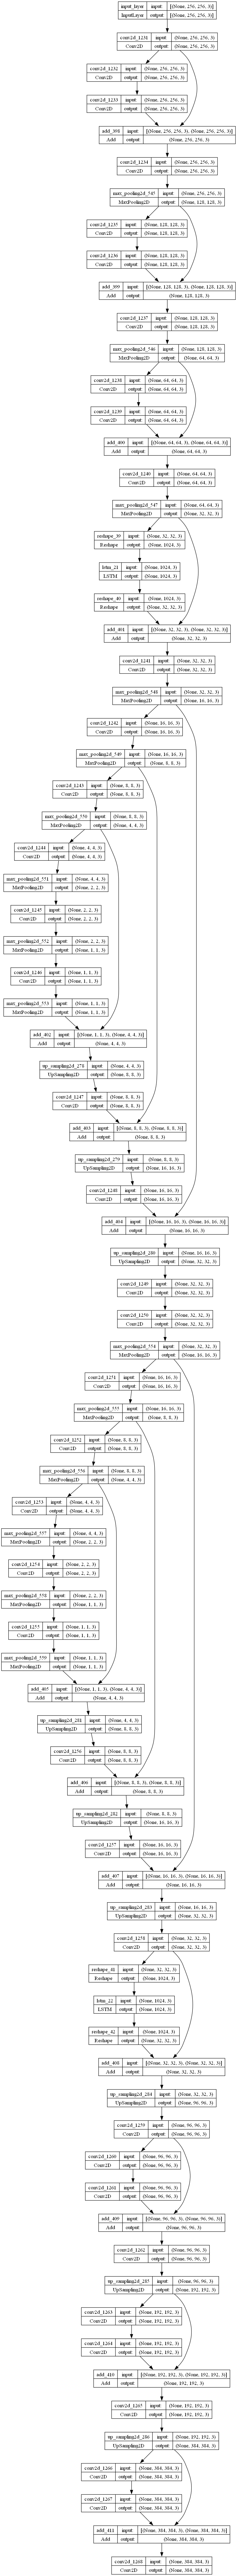

In [125]:
#input_shape = (256, 256, 3)
#baseModel = create_models(dropout = False, dropout_rate = 0.2, model_name = 'base', input_shape =(256, 256, 3), filters = 3)
#dot_image_file = 'base_model.png'


CNN_LSTM2 = create_models(dropout = False, dropout_rate = 0.2, model_name = 'CNN-2LSTM', input_shape =(256, 256, 3), filters = 3)
dot_image_file = 'CNN_2LSTMs.png'
keras.utils.plot_model(CNN_LSTM2, to_file=dot_image_file, show_shapes=True)

In [ ]:
model, history = train_models(x, y, x_test = None, y_test = None, epochs = 250, batch_size = 8)


## Can be used to produce high detail images of each model

In [ ]:
#dot_image_file = 'base_model.png'
#keras.utils.plot_model(baseModel, to_file=dot_image_file, show_shapes=True)

def hourglass_module(x, filters):
    # First Residual Block
    x_res1 = residual_block(x, filters)

    # Downsampling
    x_downsampled = MaxPooling2D((2, 2), padding='same')(x_res1)

    # Second Residual Block
    x_res2 = residual_block(x_downsampled, filters)

    # Upsampling
    x_upsampled = UpSampling2D((2, 2))(x_res2)

    # Skip connection to the original input
    x_skip = Conv2D(filters, (1, 1), padding='same')(x)

    # Resize x_upsampled to match the shape of x_skip_resized
    x_upsampled_resized = tf.image.resize(x_upsampled, size=tf.shape(x_skip)[1:3], method='nearest')

    # Skip connection with the upsampled features
    x = Add()([x_skip, x_upsampled_resized])

    return x

def residual_block(x, filters, kernel_size=3, strides=1):
    y = Conv2D(filters, kernel_size, strides=strides, padding='same')(x)
    y = Activation('relu')(y)
    y = Conv2D(filters, kernel_size, padding='same')(y)

    # Adjust the shortcut connection to match the dimensions
    shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(x)
    y = Add()([y, shortcut])

    y = Activation('relu')(y)
    return y

def encoder_decoder(input_shape, level_1_features=16, level_2_features=32, level_3_features=64):
    output_shape = input_shape[-1]
    # Input layer
    inputs = Input(shape=input_shape)

    # First convolution layer
    conv1 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(inputs)

    # Second convolution layer
    conv2 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(conv1)
#     conv2 = Activation('relu')(conv2)

    # Third convolution layer
    conv3 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(conv2)
#     conv3 = Activation('relu')(conv3)
    conv4Input = Add()([conv3, conv1])

    # Fourth convolution layer with a residual connection
    conv4 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv4Input)
#     conv4 = Activation('relu')(conv4)
    
    #Max pooling after conv4
    conv4_pooled = MaxPooling2D((2, 2))(conv4)

    # fifth convolution layer 
    conv5 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv4_pooled)
#     conv5 = Activation('relu')(conv5)
    
    # sixth convolution layer 
    conv6 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(conv5)
#     conv6 = Activation('relu')(conv6)
    
    conv7Input = Add()([conv6, conv4_pooled])
    
    # seventh convolution layer with a residual connection
    conv7 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv7Input)
#     conv7 = Activation('relu')(conv7)
    
    #Max pooling after conv7
    conv7_pooled = MaxPooling2D((2, 2), padding='same')(conv7)
    
    # eight convolution layer 
    conv8 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv7_pooled)
#     conv8 = Activation('relu')(conv8)
    
    # nineth convolution layer 
    conv9 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv8)
#     conv9 = Activation('relu')(conv9)
    
    conv10Input = Add()([conv9, conv7_pooled])
    
    #tenth convolutional layer with residual connection
    conv10 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(conv10Input)
#     conv10 = Activation('relu')(conv10)
    
    #max pooling after conv10
    conv10_pooled = MaxPooling2D((2, 2), padding='same')(conv10)
    
    #This needs to fed into the Hour Glass
    
#     hourGlass1Output = hourglass_module(conv10_pooled, 64)
       # Stacked Hourglass
    hourglass = conv10_pooled
    for _ in range(4):  # You can adjust the number of stacked hourglass modules
        hourglass = hourglass_module(hourglass, 128) 
        
    for _ in range(4):  # You can adjust the number of stacked hourglass modules
        hourglass = hourglass_module(hourglass, 128) 
        

    dec_conv1 = UpSampling2D((2, 2))(hourglass)
    
    dec_conv2 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv1) # this output gets added to output of conv 4
    
    dec_conv3 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv2)
    
    dec_conv4 = Conv2D(level_3_features, (3, 3), padding='same', activation='relu')(dec_conv3)
    
    dec_conv5Input = Add()([dec_conv4, dec_conv2])
    
    dec_conv5 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv5Input)
    dec_conv6 = UpSampling2D((2, 2))(dec_conv5) # add this to output of conv 8
    
    dec_conv7 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv6)
    dec_conv8 = Conv2D(level_2_features, (3, 3), padding='same', activation='relu')(dec_conv7)
    
    dec_conv9Input = Add()([dec_conv8, dec_conv6])
    
    dec_conv9 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv9Input)
    dec_conv10 = UpSampling2D((2, 2))(dec_conv9) # add this to output of conv 12

    dec_conv11 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv10)
    dec_conv12 = Conv2D(level_1_features, (3, 3), padding='same', activation='relu')(dec_conv11)
    
    dec_conv13Input = Add()([dec_conv12, dec_conv10])

    dec_conv13 = Conv2D(output_shape, (3, 3), padding='same', activation='relu')(dec_conv13Input)
    
    model = tf.keras.models.Model(inputs=input_layer, outputs=dec_conv13)
    return model

input_shape = (256, 256, 3)
baseModel = encoder_decoder(input_shape, level_1_features=16, level_2_features=32, level_3_features=64)

dot_image_file = 'base_model.png'
keras.utils.plot_model(baseModel, to_file=dot_image_file, show_shapes=True)